<a href="https://colab.research.google.com/github/ryosuke0624/image_search_minimum/blob/master/shoes_image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# このノートブックについて

このnotebookは画像検索の仕組みを最小限のコードで実現するものです。画像データを畳み込みニューラルネットワークで低次元空間の点に圧縮し、その空間上で近傍探索を行うという方針で行います。

## 利用するデータセット

利用するデータはECサイト zappos.comから集められたシューズに関する画像セットです。

UT Zappos50K
http://vision.cs.utexas.edu/projects/finegrained/utzap50k/

この画像セットには、50025のシューズの画像が含まれていて、シューズ、サンダル、スリッパ、ブーツの４つを大きなカテゴリに分けられます。白い背景の中心にシューズが映っており、同じ方向を向いています。


## 利用するPythonライブラリ

畳み込みニューラルネットワークの学習と推論には、fastaiライブラリを使用します。これは深層学習フレームワークのPyTorchをベースにしており、各テクニックを簡単に利用することができるように書かれた学習者向けのライブラリです。

近傍探索にはAnnoyというライブラリを利用します。大量のデータを検索する上で、重要なテクニックになります。

---



# データの準備

In [1]:
# 画像データのダウンロード
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip

# ファイルの解凍
!unzip -qq ut-zap50k-images.zip

--2020-08-14 06:38:41--  http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.120.116
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.120.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305323328 (291M) [application/zip]
Saving to: ‘ut-zap50k-images.zip’

ut-zap50k-images.zi 100%[===================>] 291.18M  24.0MB/s    in 13s     

2020-08-14 06:38:54 (22.6 MB/s) - ‘ut-zap50k-images.zip’ saved [305323328/305323328]



In [2]:
import glob
import shutil
from pathlib import Path

cat_path_list = glob.glob("ut-zap50k-images/*/*")
cat_list = ['-'.join(path.replace(" ", "_").split('/')[1:]) for path in cat_path_list]

!mkdir images

# 詳細カテゴリごとにディレクトリを分けて画像を保存する
for i, cat_path in enumerate(cat_path_list):
  p = Path(f'images/{cat_list[i]}')
  if not p.exists():
    p.mkdir()
  for image_path in glob.glob(cat_path + '/*/*'):
    dest = shutil.move(image_path, f'images/{cat_list[i]}/{Path(image_path).name}')

In [3]:
import os
import numpy as np
import pandas as pd

# Any results you write to the current directory are saved as output.
import gc
gc.collect()

336

In [5]:
import fastai
from fastai import *
from fastai.vision import *

import sys

from fastai.callbacks.hooks import *
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

In [34]:
path = Path("images/")

# データオーグメンテーション
# https://docs.fast.ai/vision.transform.html#Image-transforms

# 今回のデータセットには回転や反転、拡大、ライトニングは不要
tfms = get_transforms(
    #max_rotate= 10.,
    #max_zoom=1.,
    #max_lighting=0.20,
    do_flip=False,
    #max_warp=0.,
    #xtra_tfms=[flip_lr(), brightness(change=(0.3, 0.60), p=0.7), contrast(scale=(0.5, 2), p=0.7),
    #                                          crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.),
    #                                          rand_zoom(scale=(1.,1.5)), rand_crop(),
    #                                          perspective_warp(magnitude=(-0.1,0.1)),
    #                                          symmetric_warp(magnitude=(-0.1,0.1)) ]
    )

src = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2, seed=42)
        .label_from_folder())

In [35]:
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, padding_mode='border', size=128)
        .databunch(bs=64, num_workers=0)
        .normalize(imagenet_stats))

In [36]:
data

ImageDataBunch;

Train: LabelList (40020 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Shoes-Loafers,Shoes-Loafers,Shoes-Loafers,Shoes-Loafers,Shoes-Loafers
Path: images;

Valid: LabelList (10005 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Boots-Ankle,Sandals-Flat,Shoes-Sneakers_and_Athletic_Shoes,Boots-Ankle,Shoes-Heels
Path: images;

Test: None

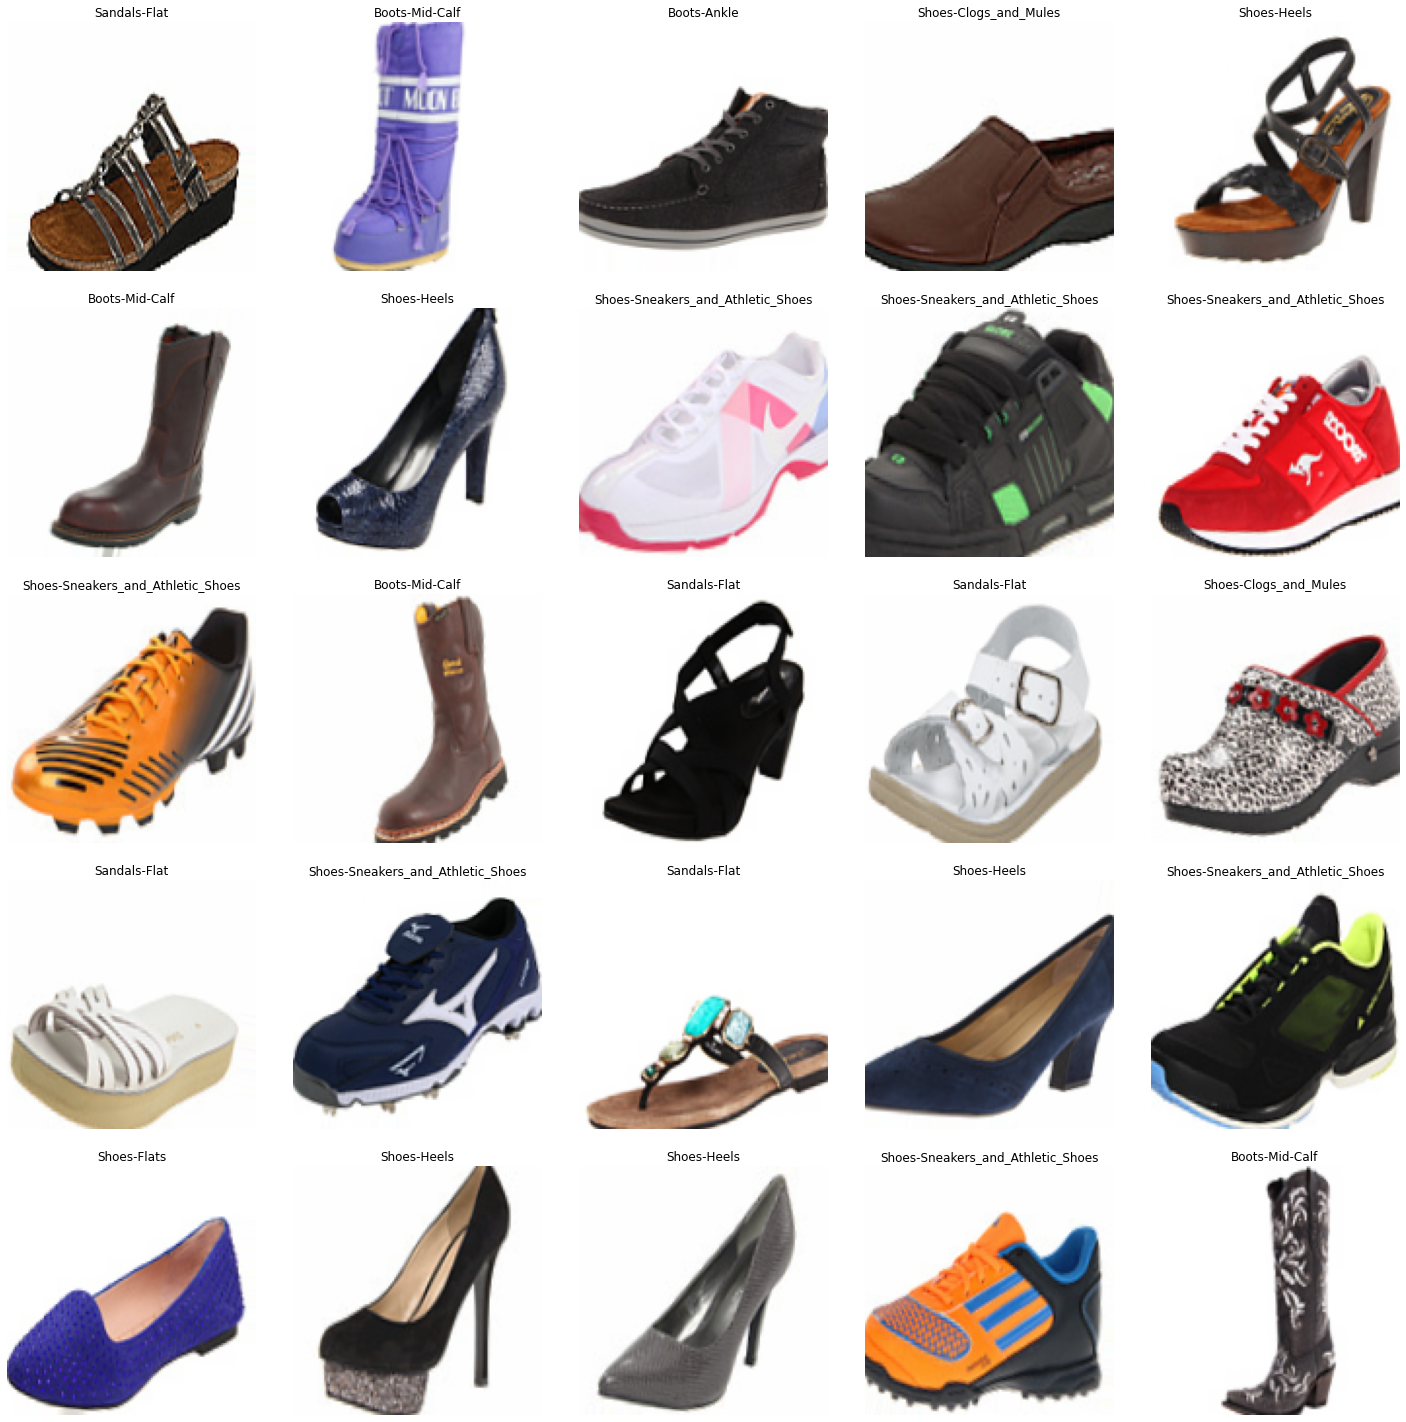

In [37]:
data.show_batch()

In [38]:
print(f'Classes: \n {data.classes}')
print(f'Class num: {len(data.classes)}')

Classes: 
 ['Boots-Ankle', 'Boots-Knee_High', 'Boots-Mid-Calf', 'Boots-Over_the_Knee', 'Boots-Prewalker_Boots', 'Sandals-Athletic', 'Sandals-Flat', 'Sandals-Heel', 'Shoes-Boat_Shoes', 'Shoes-Clogs_and_Mules', 'Shoes-Crib_Shoes', 'Shoes-Firstwalker', 'Shoes-Flats', 'Shoes-Heels', 'Shoes-Loafers', 'Shoes-Oxfords', 'Shoes-Prewalker', 'Shoes-Sneakers_and_Athletic_Shoes', 'Slippers-Boot', 'Slippers-Slipper_Flats', 'Slippers-Slipper_Heels']
Class num: 21


# モデルの学習

In [32]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir="model" ).mixup()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 1.00E-02


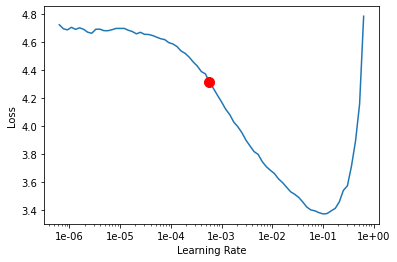

In [33]:
# 適切な学習率を探索する
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [39]:
# 学習率を定めて、学習を実施する
lr=1e-3
learn.fit_one_cycle(2, max_lr=slice(1e-2), wd = (1e-6, 1e-4, 1e-2), pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,1.228683,0.624121,0.790505,06:47
1,0.995879,0.469827,0.843078,06:45


In [ ]:
learn.save('zappos_final_model')

# 画像の特徴量抽出

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [ ]:
# Second last layer of the model
learn.model[1][4]

Linear(in_features=4096, out_features=512, bias=True)

In [ ]:
sf = SaveFeatures(learn.model[1][4])

In [ ]:
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [ ]:
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) + list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]

In [ ]:
df_new = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
df_new['img_repr'] = np.array(sf.features).tolist()

# 近似近傍探索

In [ ]:
!pip install annoy
from annoy import AnnoyIndex

     |████████████████████████████████| 645kB 11.2MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297332 sha256=096ae782cda123240026cd60fa962eb4253be21271cf3f79b3714352ec0b305f
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [ ]:
f = len(df_new['img_repr'][0])
t = AnnoyIndex(f, metric='euclidean')

In [ ]:
ntree = 50

for i, vector in enumerate(df_new['img_repr']):
    t.add_item(i, vector)
_  = t.build(ntree)

In [ ]:
import time
def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = df_new.iloc[img_index, [0, 3, 1]]
    similar_img_ids = t.get_nns_by_item(img_index, 12)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [ ]:
base_image, base_label, similar_images_df = get_similar_images_annoy(1000)

1.8739700317382812 ms


In [ ]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learn.data.show_xys(images, categories, figsize=(10, 10))

1.8875598907470703 ms


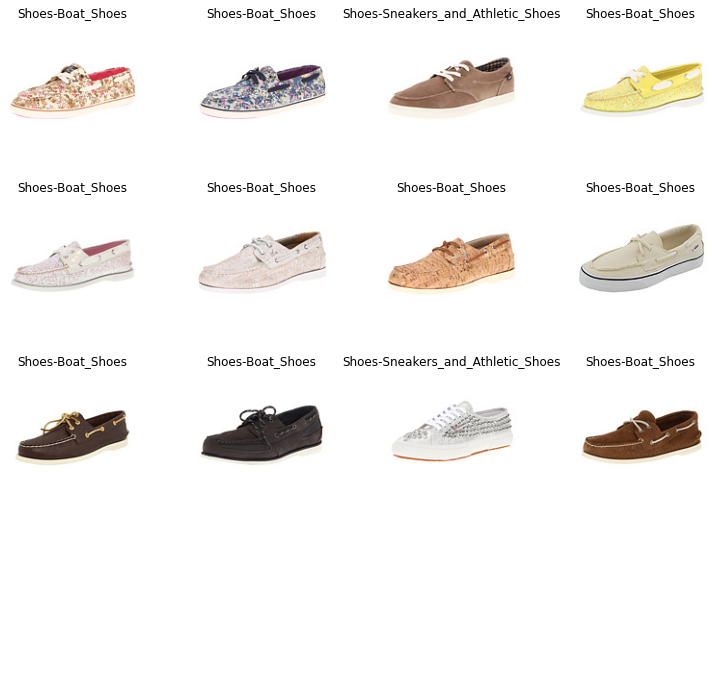

In [ ]:
base_image, base_label, similar_images_df = get_similar_images_annoy(3)
show_similar_images(similar_images_df)